In [3]:
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Evaluation
from sklearn.model_selection import cross_val_score, KFold

In [4]:
%matplotlib inline
#['classic', 'seaborn-colorblind', 'seaborn-darkgrid', 'seaborn-muted', 'seaborn-dark', 
#'seaborn-white', 'fivethirtyeight', 'seaborn-whitegrid', 'seaborn', 'dark_background', 
#'grayscale', 'seaborn-talk', 'ggplot', 'bmh', 'seaborn-bright', 'seaborn-poster', 'seaborn-ticks', 
#'seaborn-pastel', 'seaborn-paper', 'seaborn-dark-palette', 'seaborn-notebook', 'seaborn-deep']

mpl.style.use( 'classic' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6


# Load data

In [5]:
train = pd.read_csv("data/train.csv")
test    = pd.read_csv("data/test.csv")
full_df = train.append(test, ignore_index = True)

# Exploratory data analysis

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
types = train.columns.to_series().groupby(train.dtypes).groups
for k,v in types.items():
    print(k, v)

int64 ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch']
object ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
float64 ['Age', 'Fare']


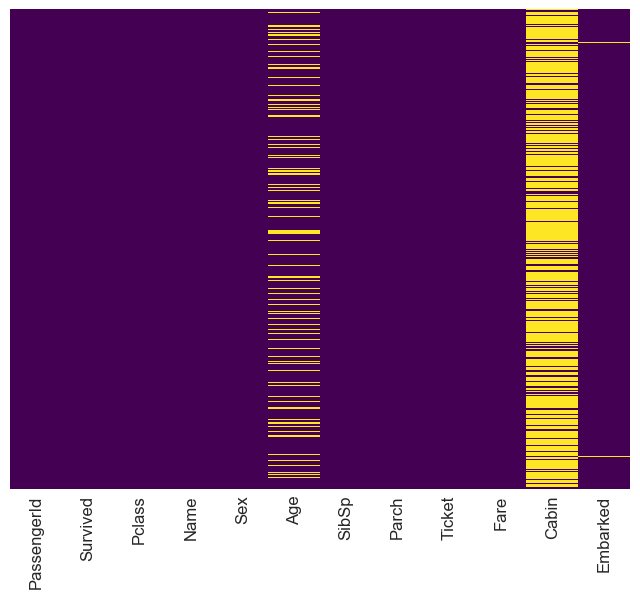

In [9]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

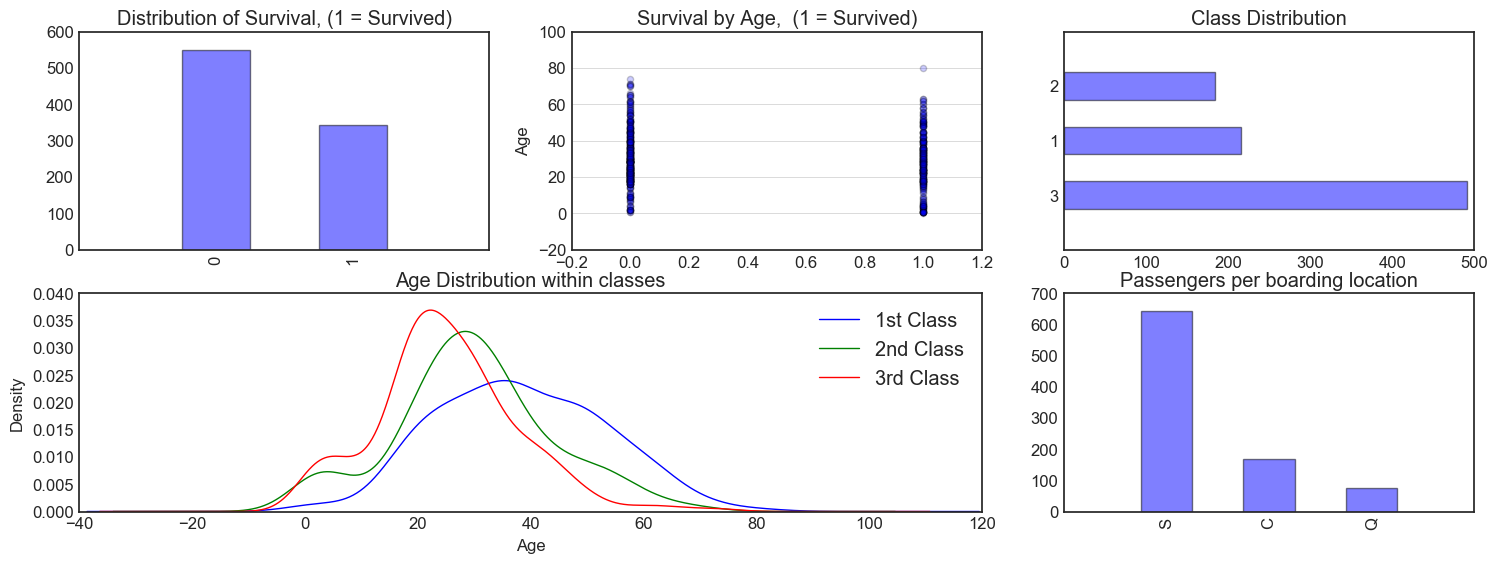

In [10]:
fig = plt.figure(figsize=(18,6)) 

ax1 = plt.subplot2grid((2,3),(0,0))
train.Survived.value_counts().plot(kind='bar', alpha=0.5)
plt.title("Distribution of Survival, (1 = Survived)")    
ax1.set_xlim(-1, 2)

plt.subplot2grid((2,3),(0,1))
plt.scatter(train.Survived, train.Age, alpha=0.2)
plt.ylabel("Age")
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
train.Pclass.value_counts().plot(kind="barh", alpha=0.5)
ax3.set_ylim(-1, len(train.Pclass.value_counts()))
plt.title("Class Distribution")

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
train.Age[train.Pclass == 1].plot(kind='kde')    
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
train.Embarked.value_counts().plot(kind='bar', alpha=0.5)
ax5.set_xlim(-1, len(train.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")


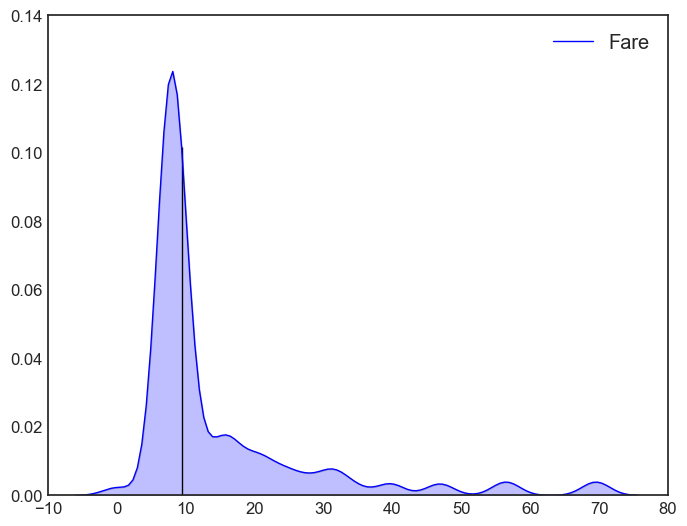

In [14]:
#train.Fare[(train.Pclass == 3) & (train.Embarked == 'S')].plot(kind='kde')    
import scipy
p=sns.kdeplot(train.Fare[(train.Pclass == 3) & (train.Embarked == 'S')], shade=True)

x,y = p.get_lines()[0].get_data()

#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()

x_median = x[nearest_05]
y_median = y[nearest_05]

plt.vlines(x_median, 0, y_median)
plt.show()



In [15]:
train.Fare[(train.Pclass == 3) & (train.Embarked == 'S')].median()

8.05

(-1, 2)

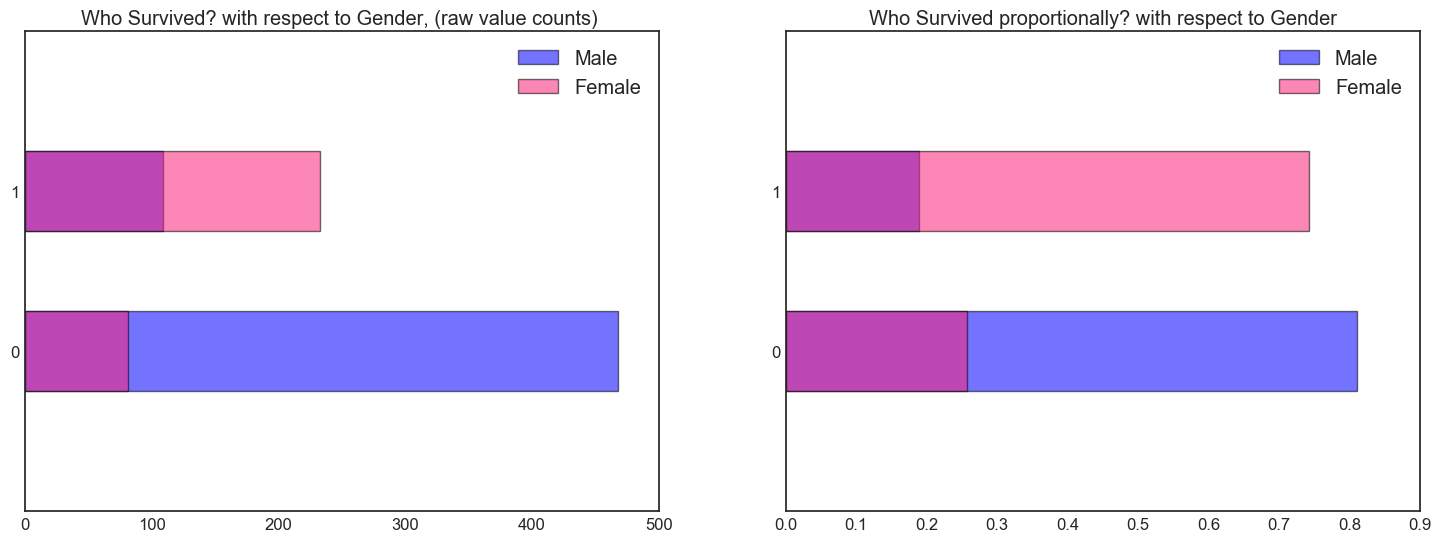

In [12]:
fig = plt.figure(figsize=(18,6))

df_male = train.Survived[train.Sex == 'male'].value_counts().sort_index()
df_female = train.Survived[train.Sex == 'female'].value_counts().sort_index()

ax1 = fig.add_subplot(121)
df_male.plot(kind='barh',label='Male', alpha=0.55)
df_female.plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived? with respect to Gender, (raw value counts) "); plt.legend(loc='best')
ax1.set_ylim(-1, 2) 

ax2 = fig.add_subplot(122)
(df_male/float(df_male.sum())).plot(kind='barh',label='Male', alpha=0.55)  
(df_female/float(df_female.sum())).plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived proportionally? with respect to Gender"); plt.legend(loc='best')

ax2.set_ylim(-1, 2)

In [4]:
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

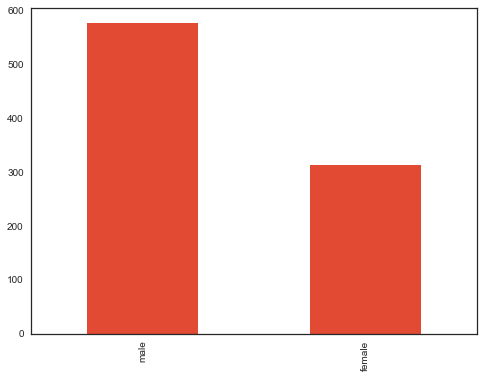

In [5]:
train.Sex.value_counts().plot(kind='bar')

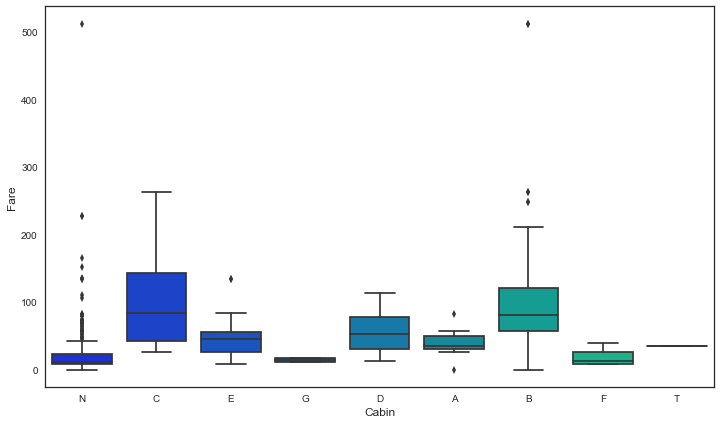

In [8]:
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return 'None'

 
train['Cabin'] = train.Cabin.apply(clean_cabin)

plt.figure(figsize=(12, 7))
sns.boxplot(x='Cabin',y='Fare',data=train,palette='winter')

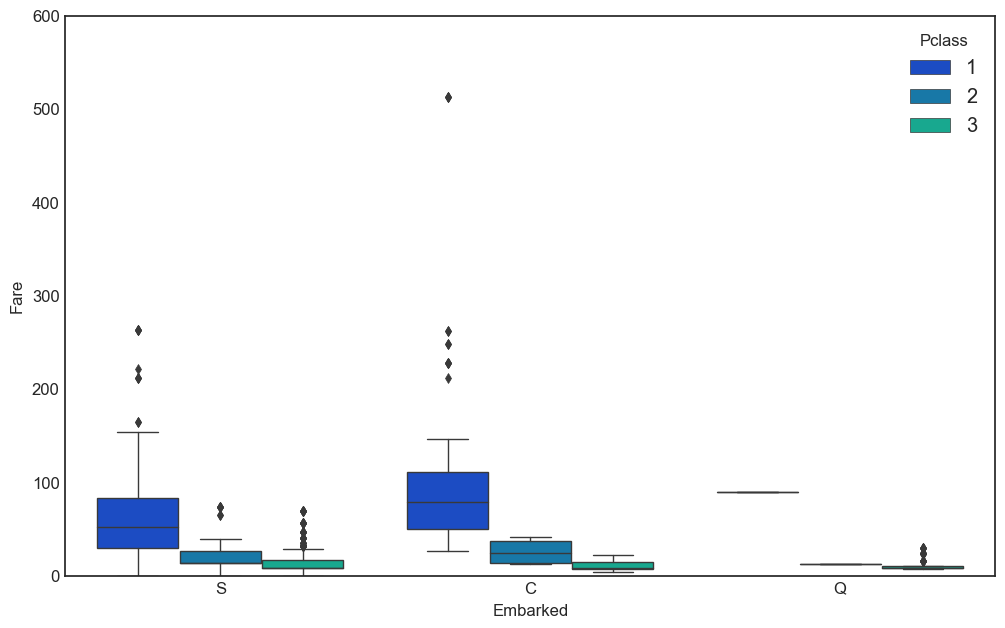

In [5]:
# # cols = {}
# # train[train.Embarked.isnull()]
# # 2 missing values for embarked, they have pclass=1 and Fare = 80
# the boxplot below shows that for class1 and embarked C the mean value of a fare is 80, so we can assume the missing
# embarked is C
plt.figure(figsize=(12, 7))
sns.boxplot(x='Embarked',y='Fare',data=train, hue='Pclass', palette='winter')

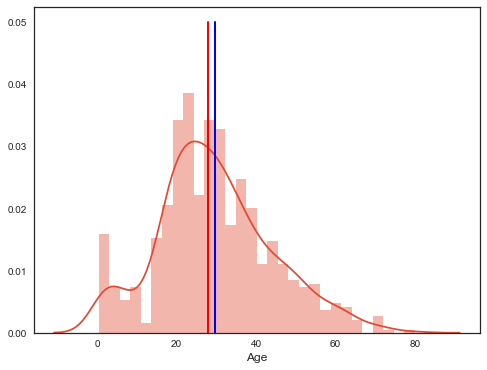

In [11]:
median = train['Age'].median()
mean = train['Age'].mean()
sns.distplot(train['Age'].dropna(), bins=30)
plt.plot([median, median], [0, 0.05], linewidth=2, c='r')
plt.plot([mean, mean], [0, 0.05], linewidth=2, c='b')

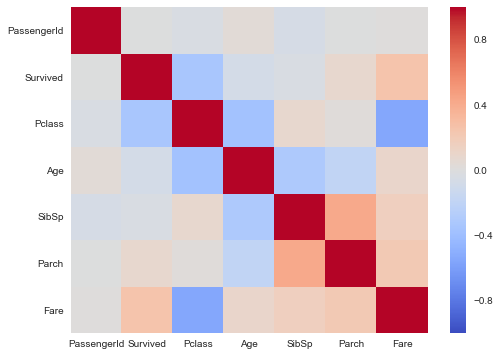

In [12]:
sns.heatmap(train.corr(),cmap='coolwarm')

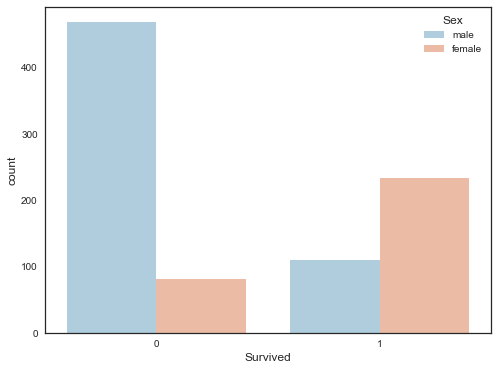

In [14]:
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

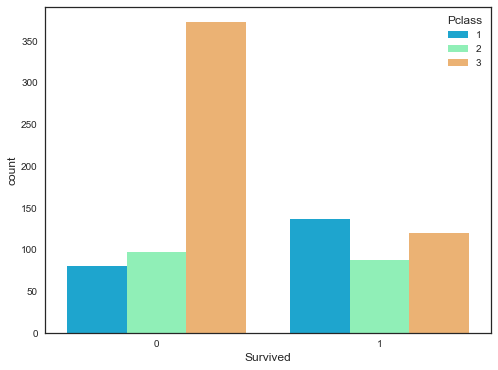

In [15]:
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

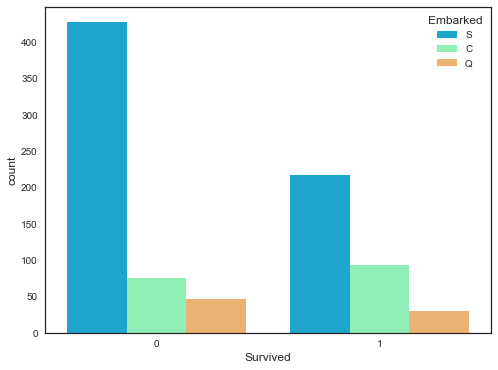

In [16]:
sns.countplot(x='Survived',hue='Embarked',data=train,palette='rainbow')

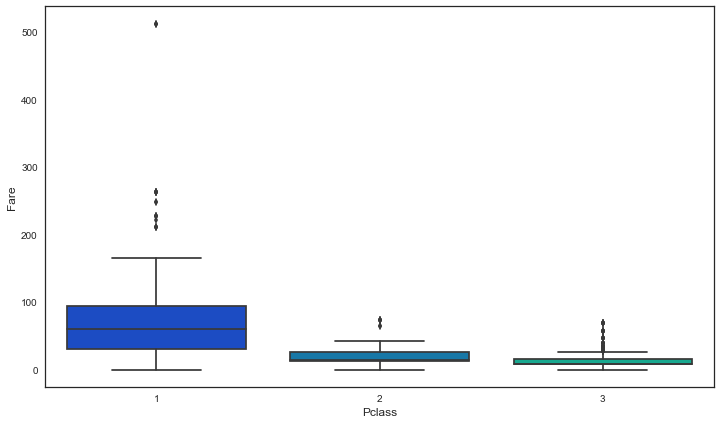

In [17]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Fare',data=train,palette='winter')

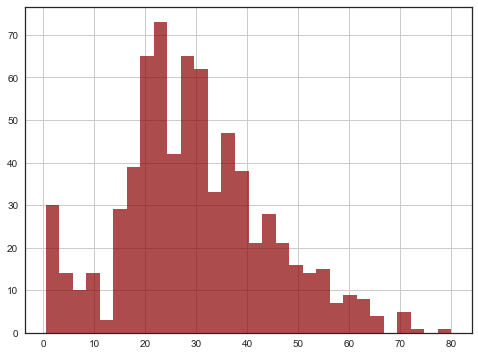

In [18]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

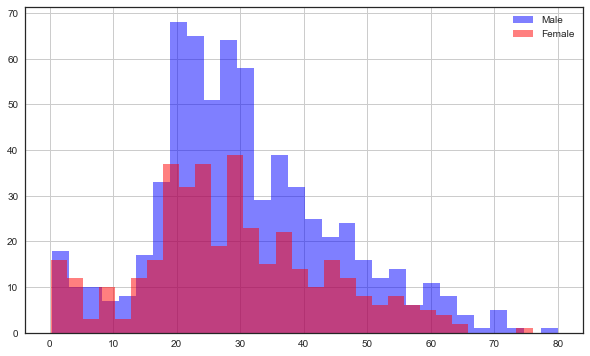

In [19]:
plt.figure(figsize=(10,6))
full_df[full_df['Sex']=='male']['Age'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Male')
full_df[full_df['Sex']=='female']['Age'].hist(alpha=0.5,color='red',
                                              bins=30,label='Female')
plt.legend()


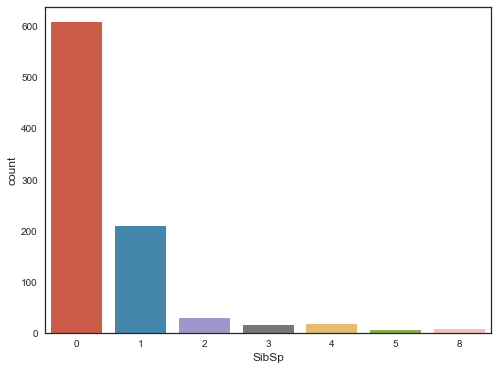

In [20]:
sns.countplot(x='SibSp',data=train)

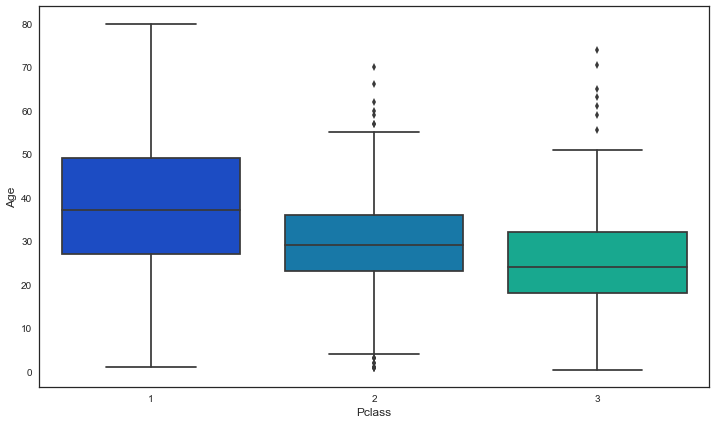

In [21]:
# avg age per class
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

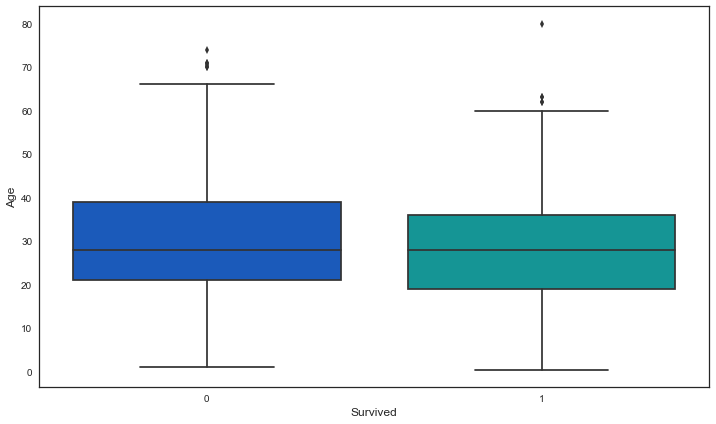

In [22]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Survived',y='Age',data=train,palette='winter')